# Setup

**Imports**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)
#from scipy.special import precomputed

**Utility functions**

In [3]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Spectral feature

## Question 6

In [4]:
def plot(x, y, xlabel, ylabel):
    fig, ax = fig_ax(figsize=(9, 5))
    
    avg = y.mean(axis=0)
    std = y.std(axis=0)
    
    ax.plot(x, avg, 'k-')
    ax.fill_between(x, avg-std, avg+std, alpha=0.5)
    ax.legend(['Mean', 'Stdandard deviation'], loc='upper right')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [5]:
from statsmodels.tsa.stattools import acovf
from scipy.signal import periodogram

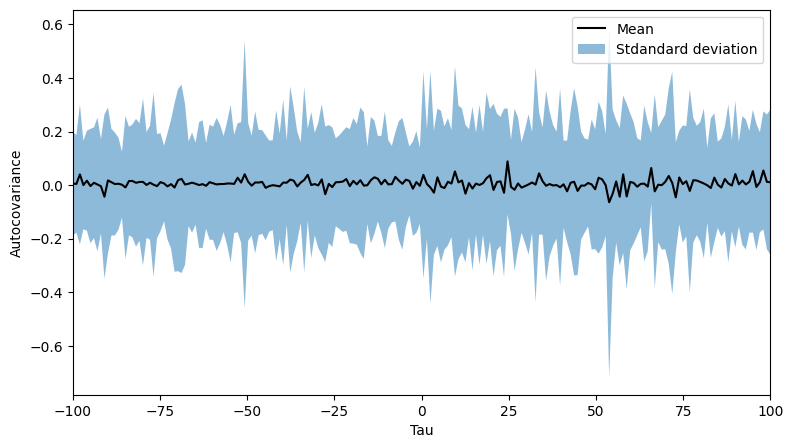

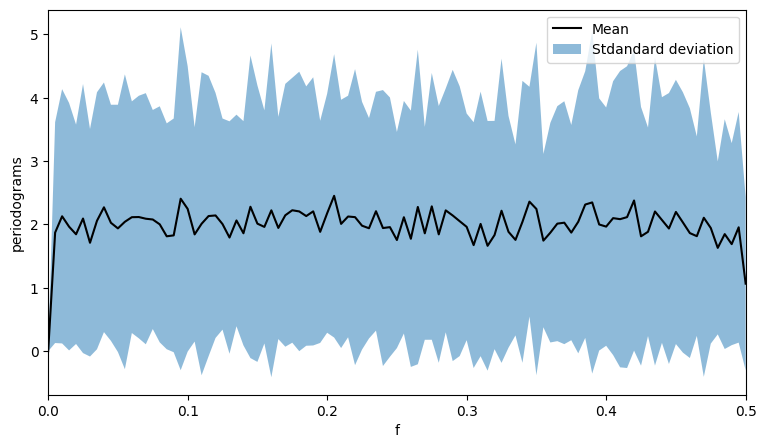

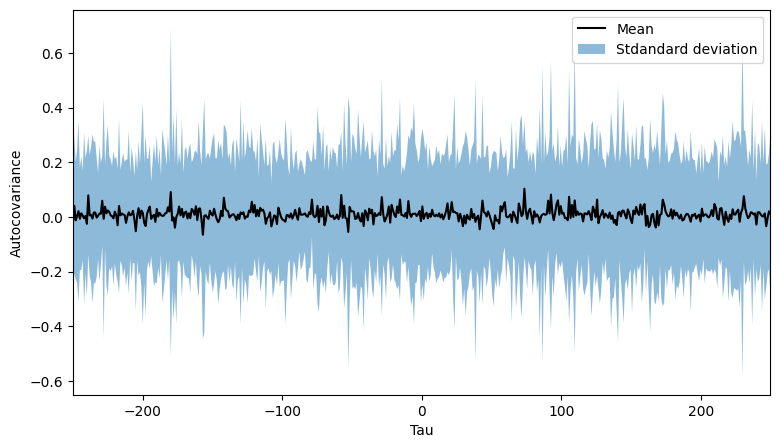

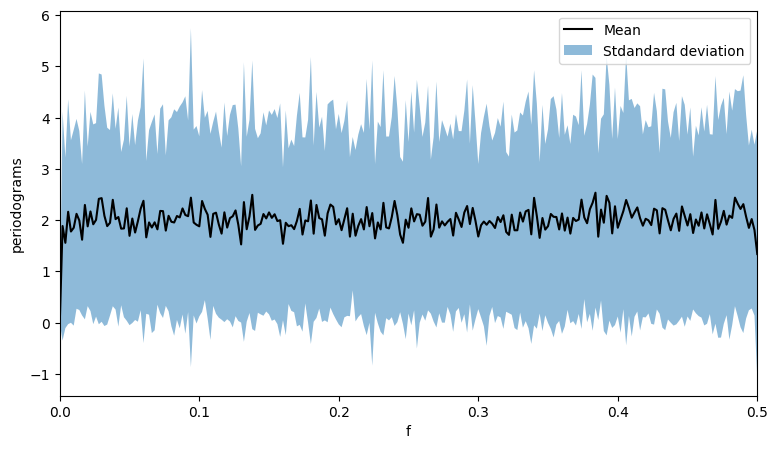

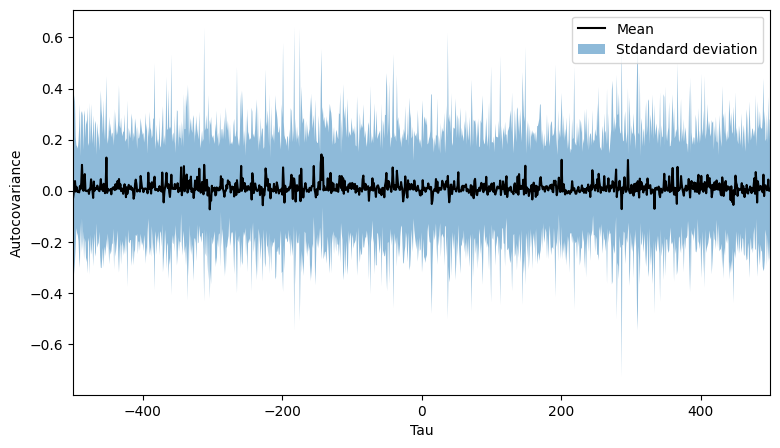

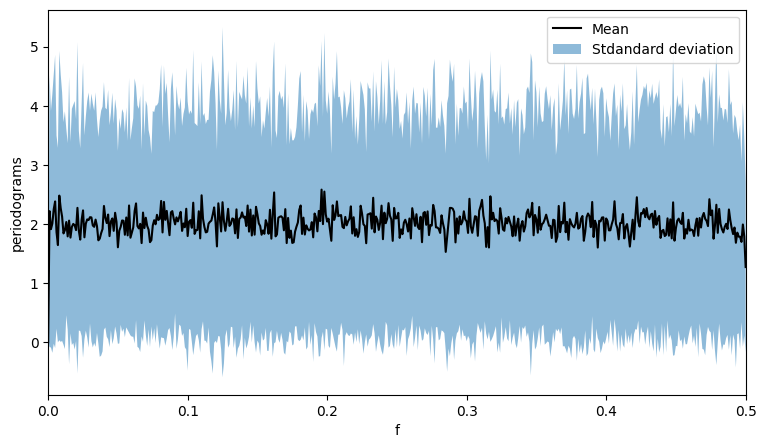

In [11]:
# This is an example of plot (random data). You can change it if you want.
N_list = [200, 500, 1000]
n_simulation = 100

for N in N_list:
    X = np.random.randn(n_simulation, N)  # shape (n_trials, n_freqs)
    tau = np.linspace(-N//2, N//2, N)
    
    autocovariances = np.apply_along_axis(lambda x: acovf(x, adjusted = True, demean = False, fft = False), 0, X)
    plot(tau, autocovariances, "Tau", "Autocovariance")

    freqs, periodograms = periodogram(X, fs = 1)
    plot(freqs, periodograms, "f", "periodograms")

## Question 9

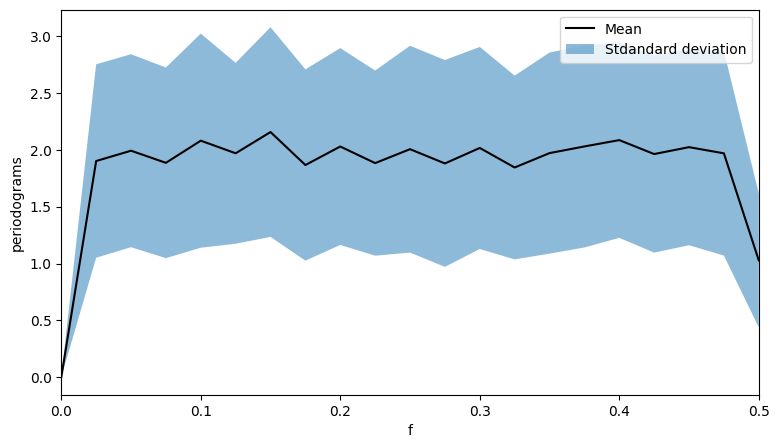

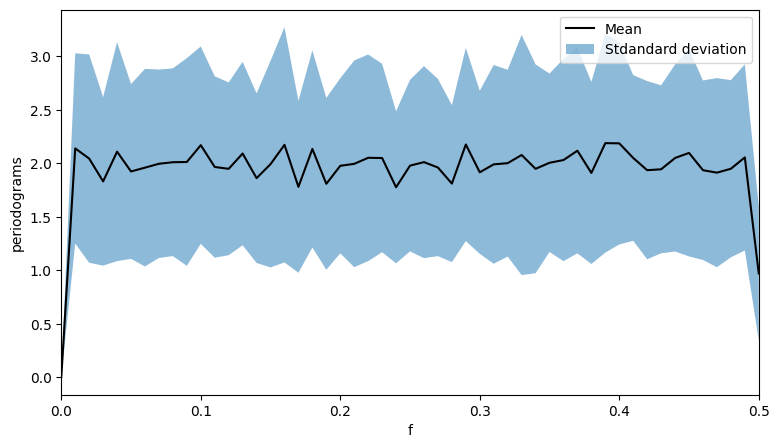

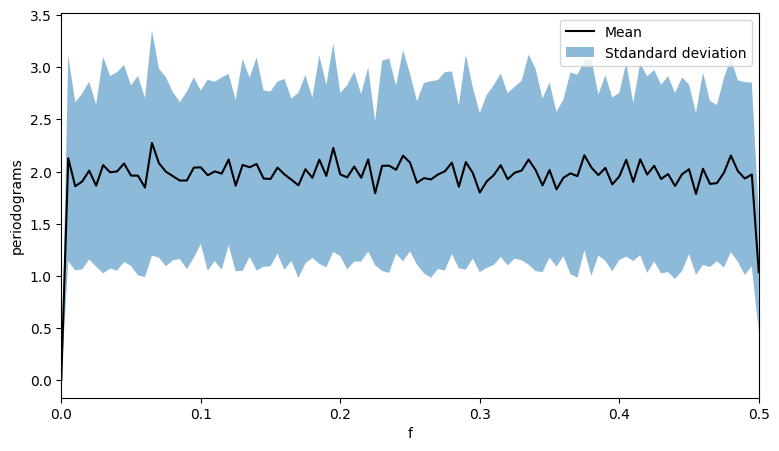

In [7]:
from scipy.signal import periodogram

n_simulation = 100 
N_list = [200, 500, 1000]
K = 5

for N in N_list:
    X = np.random.randn(n_simulation, N)
    section_length = N//K
    
    sections = np.array([X[:,k*section_length:(k+1)*section_length] for k in range(K)])
    
    periodograms = np.zeros((K, n_simulation, (N//2)//K + 1))
    for k in range(K):
        freq, periodo = periodogram(sections[k])
        periodograms[k,:,:] = periodo
    
    barlett_estimate = periodograms.mean(axis=0)
    plot(freq, barlett_estimate, "f", "periodograms")
    

# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [58]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

## Question 10

In [78]:
from sklearn import model_selection
from sklearn.metrics import f1_score, confusion_matrix
from tslearn import neighbors
from tslearn.utils import to_time_series_dataset

In [60]:
X_train = to_time_series_dataset(X_train)
X_test = to_time_series_dataset(X_test)

In [61]:
n_neighbors_range = [i for i in range(1, 20)]
parameters = {'n_neighbors': n_neighbors_range}
knc = neighbors.KNeighborsTimeSeriesClassifier(metric='dtw')

gridsearch = model_selection.GridSearchCV(knc, parameters, n_jobs=-1, cv=5, scoring='f1')

gridsearch.fit(X_train, y_train)
print("meilleur estimateur trouvé pour n_neighbors:")
print(gridsearch.best_params_)

meilleur estimateur trouvé pour n_neighbors:
{'n_neighbors': 5}


In [62]:
gridsearch.best_score_

np.float64(0.781814185073362)

In [65]:
y_pred = gridsearch.predict(X_test)
f1_score(y_test, y_pred)

np.float64(0.5132743362831859)

In [79]:
print(confusion_matrix(y_test, y_pred))

[[ 4 11]
 [44 29]]


## Question 11

In [70]:
badly_classified_healthy = []
badly_classified_non_healthy = []

k = 0
while not(y_test[k] == 0 and y_pred[k] == 1):
    k += 1
badly_classified_healthy.append(k)

l = 0
while not(y_test[l] == 1 and y_pred[l] == 0):
    l += 1
badly_classified_non_healthy.append(l)

##### Badly classified healthy step

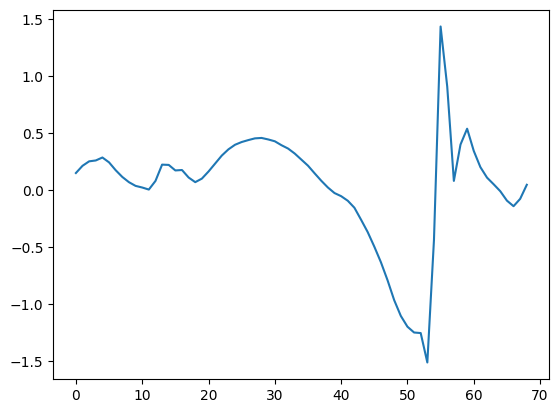

In [81]:
plt.plot(X_test[badly_classified_healthy[0]])

##### Badly classified non-healthy step


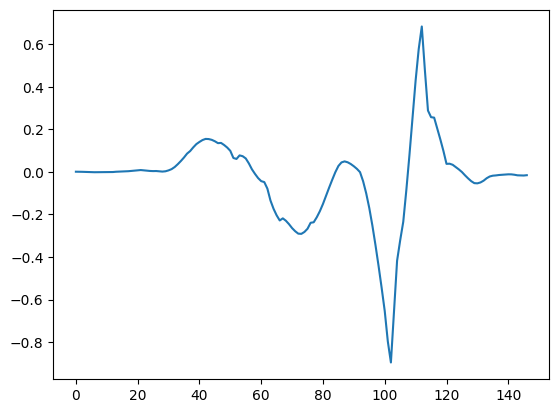

In [82]:
plt.plot(X_test[badly_classified_non_healthy[0]])